# Embeddings model

In [1]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt

#import cPickle as pickle
import pickle
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython.display import clear_output

import keras

Using TensorFlow backend.


First, we will load our image paths and feature vectors from the previous notebook into memory. We can print their contents to get an idea of what they look like:

In [2]:
# ORIGINAL DATASET
path = '/home/kangeunsu/facenet/embeddings_from_celeb_30k_noflip_160px.p'
directory = "/home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/"

# load features
full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
print("full_features : ",len(full_features), len(full_features[0]))

import fnmatch
# load images
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths

images_ORIG_loaded = images_mine
pca_features_ORIG = full_features

for i, f in list(zip(images_ORIG_loaded, pca_features_ORIG))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

full_features :  30000 512
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000000.png, features: -0.08,0.00,-0.03,-0.02... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000001.png, features: -0.05,0.07,-0.02,0.07... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000002.png, features: -0.06,0.03,0.00,0.05... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000003.png, features: -0.08,0.03,0.01,0.06... 
image: /home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/img00000004.png, features: -0.03,0.05,-0.04,0.07... 


In [3]:
# GENERATED DATASET
#1.3G Apr 20 14:07 embeddings_from_100k_generated_images_no_flips.p
path = '/home/kangeunsu/facenet/embeddings_from_100k_generated_images_no_flips.p'
#directory = "/home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_generated/"
directory = "/home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/" # not the source images = but downscaled ones, which can serve as tiles

# load features
full_features = pickle.load(open(path, 'rb'), encoding='latin1')
full_features = full_features[0]
print("full_features : ",len(full_features), len(full_features[0]))

import fnmatch
# load images
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths

images_GEN_loaded = images_mine
pca_features_GEN = full_features

for i, f in list(zip(images_GEN_loaded, pca_features_GEN))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

full_features :  100000 512
image: /home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/000000.png, features: -0.02,-0.01,-0.03,0.07... 
image: /home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/000001.png, features: -0.08,-0.02,-0.01,0.03... 
image: /home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/000002.png, features: -0.01,0.02,-0.06,0.06... 
image: /home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/000003.png, features: 0.03,-0.05,-0.07,0.04... 
image: /home/kangeunsu/CelebAHQ_generated_images/200-celebahq-1024x1024/100k_resized_generated/000004.png, features: -0.02,0.01,-0.03,0.07... 


In [4]:
num_images_to_plot_ORIG = 30000
num_images_to_plot_GEN = 30000 # should be fair representation
print(len(images_ORIG_loaded), len(images_GEN_loaded), len(pca_features_ORIG), len(pca_features_GEN))

y_original = np.ones(len(pca_features_ORIG))
y_generated = np.zeros(len(pca_features_GEN))

print(len(y_original), len(y_generated))


30000 100000 30000 100000
30000 100000


In our dataset that we've loaded, there are 9144 images. Although in principle, t-SNE works with any number of images, it's difficult to place that many tiles in a single image. So instead, we will take a random subset of 1000 images and plot those on a t-SNE instead. This step is optional.

In [5]:
# Shuffle

images_ORIG_shuffled = images_ORIG_loaded
images_GEN_shuffled = images_GEN_loaded
print("Total images: ", len(images_ORIG_loaded), "orig and ", len(images_GEN_loaded), "gen")
pca_features_ORIG_shuffled = pca_features_ORIG
pca_features_GEN_shuffled = pca_features_GEN
print("Total features: ", len(pca_features_ORIG), "orig and ", len(pca_features_GEN), "gen")

y_original_shuffled = y_original
y_generated_shuffled = y_generated

if len(images_ORIG_loaded) >= num_images_to_plot_ORIG:
    sort_order = sorted(random.sample(range(len(images_ORIG_shuffled)), num_images_to_plot_ORIG))
    images_ORIG_shuffled = [images_ORIG_shuffled[i] for i in sort_order]
    pca_features_ORIG_shuffled = [pca_features_ORIG_shuffled[i] for i in sort_order]
    y_original_shuffled = [y_original_shuffled[i] for i in sort_order]
    print("shuffled originals")
    
if len(images_GEN_loaded) >= num_images_to_plot_GEN:
    sort_order = sorted(random.sample(range(len(images_GEN_shuffled)), num_images_to_plot_GEN))
    images_GEN_shuffled = [images_GEN_shuffled[i] for i in sort_order]
    pca_features_GEN_shuffled = [pca_features_GEN_shuffled[i] for i in sort_order]
    y_generated_shuffled = [y_generated_shuffled[i] for i in sort_order]
    print("shuffled generated")
    
print("After shuffling:")

print("Shuffled Original: images", len(images_ORIG_shuffled), "features", len(pca_features_ORIG_shuffled),"x",len(pca_features_ORIG_shuffled[0]))
print("Shuffled Generated: images", len(images_GEN_shuffled),"features", len(pca_features_GEN_shuffled),"x",len(pca_features_GEN_shuffled[0]))

images = np.concatenate((images_ORIG_shuffled, images_GEN_shuffled), axis=0)
pca_features = np.concatenate((pca_features_ORIG_shuffled, pca_features_GEN_shuffled), axis=0)
y = np.concatenate((y_original_shuffled, y_generated_shuffled), axis=0)

print("Combined: images", len(images), "features", len(pca_features),"x", len(pca_features[0]))
print("Y: ", len(y))

Total images:  30000 orig and  100000 gen
Total features:  30000 orig and  100000 gen
shuffled originals
shuffled generated
After shuffling:
Shuffled Original: images 30000 features 30000 x 512
Shuffled Generated: images 30000 features 30000 x 512
Combined: images 60000 features 60000 x 512
Y:  60000


In [ ]:
# Don't run PCA!

# process model

In [6]:
#data processing
# X = features of both
# Y = 0 if real, 1 if generated

data = pca_features
labels = y

In [7]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
# skip data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.33) #random_state=42


In [25]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model

inputs = Input(shape=(512,))

x = Dense(512, activation='relu')(inputs)
x = Dense(300, activation='relu')(x)
x = Dense(2, activation='relu', name='dense_2_layer')(inputs)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

#  adam rmsprop
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
#data_train, data_test, labels_train, labels_test

#history = model.fit(data_train, labels_train, epochs=100, verbose=1, validation_data=(data_test, labels_test))  # starts training
history = model.fit(data, labels, epochs=100, verbose=1)  # starts training

Epoch 1/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.6721 - acc: 0.5800
Epoch 2/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.6553 - acc: 0.6106
Epoch 3/100
60000/60000 [==============================] - 9s 156us/step - loss: 0.6486 - acc: 0.6175
Epoch 4/100
60000/60000 [==============================] - 9s 155us/step - loss: 0.6441 - acc: 0.6225
Epoch 5/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.6413 - acc: 0.6271
Epoch 6/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.6397 - acc: 0.6274
Epoch 7/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.6384 - acc: 0.6297
Epoch 8/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.6372 - acc: 0.6299
Epoch 9/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.6366 - acc: 0.6311
Epoch 10/100
60000/60000 [==============================] - 9s 155us/step - loss: 

60000/60000 [==============================] - 11s 178us/step - loss: 0.6275 - acc: 0.6258
Epoch 81/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.6275 - acc: 0.6256
Epoch 82/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.6277 - acc: 0.6265
Epoch 83/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.6275 - acc: 0.6263
Epoch 84/100
60000/60000 [==============================] - 10s 158us/step - loss: 0.6275 - acc: 0.6265
Epoch 85/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.6273 - acc: 0.6275
Epoch 86/100
28672/60000 [=============>................] - ETA: 4s - loss: 0.6261 - acc: 0.6278

In [ ]:
#print(history.history)
fig = plt.figure()
plt.title("simple model: 512 features input - Dense 512 - 300 - 2 - 1 output")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['acc'], label="acc")
#plt.plot(history.history['val_loss'], label="val_loss")
#plt.plot(history.history['val_acc'], label="val_acc")
plt.legend()

In [ ]:
plot_save_path = "/home/kangeunsu/ArtML/Embeddings/model_training/512features_Dense512-300-2_1out.pdf"
fig.savefig(plot_save_path, bbox_inches='tight')

In [ ]:
for layer in model.layers:
    print(layer.output)


In [33]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model

inputs = Input(shape=(300,))

x = Dense(256, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

#  adam rmsprop
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(data_train, labels_train, epochs=100, verbose=1, validation_data=(data_test, labels_test))  # starts training

Train on 40200 samples, validate on 19800 samples
Epoch 1/100
40200/40200 [==============================] - 8s 189us/step - loss: 0.6128 - acc: 0.6523 - val_loss: 0.5755 - val_acc: 0.6922
Epoch 2/100
40200/40200 [==============================] - 7s 186us/step - loss: 0.5443 - acc: 0.7188 - val_loss: 0.5271 - val_acc: 0.7339
Epoch 3/100
40200/40200 [==============================] - 7s 185us/step - loss: 0.5085 - acc: 0.7481 - val_loss: 0.5105 - val_acc: 0.7473
Epoch 4/100
40200/40200 [==============================] - 7s 186us/step - loss: 0.4810 - acc: 0.7673 - val_loss: 0.5042 - val_acc: 0.7512
Epoch 5/100
40200/40200 [==============================] - 7s 180us/step - loss: 0.4591 - acc: 0.7809 - val_loss: 0.5015 - val_acc: 0.7575
Epoch 6/100
40200/40200 [==============================] - 7s 176us/step - loss: 0.4372 - acc: 0.7953 - val_loss: 0.4897 - val_acc: 0.7649
Epoch 7/100
40200/40200 [==============================] - 7s 182us/step - loss: 0.4173 - acc: 0.8041 - val_loss: 0.

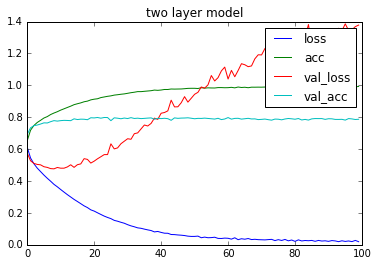

In [34]:
plt.figure()
plt.title("two layer model")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_loss'], label="val_loss")
plt.plot(history.history['val_acc'], label="val_acc")
plt.legend()